In [1]:
# Dynamic
%matplotlib notebook
# Standard
# %matplotlib inline

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas
import pickle
from scipy.stats import sem, rankdata
import seaborn as sns
import sys


# Allow to import the modules in the model folder
sys.path.append('../model/')

fig_width = 16  # full screen: 16 / half screen: 10
fig_height = 8

In [2]:
# /!\ global variables
l_seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# l_seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
#           10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

sim_nb_day = 60  # 30 or 60 for long simulations, used as the stop parameter in delta_learning_step function

plot_title = "diversity_percentage_train_per_day"  # specify the title of the plot for better identification of the figures

nb_seed = len(l_seed)

In [3]:
    def delta_learning_step(start, stop):
        """
        For each "learning step" (one day plus one night),
        calculate and store the "delta" (the difference) between
        the best score of the morning songs and the best score of the evening songs of the previous day.

        returns:
        - full_data: store the deltas for each diversity_threshold (each parameters set) 
                     and for each seeds computed under these parameters set
        - final_scores: for all the simulations, store the final score which is the best score
                        among the final songs learned by the bird
        - percent_changes
        /!\: use l_seed and coef_param as global variable
        """
        full_data = []
        final_scores = []
        percent_changes = []
        seeds_diff = None
        cluster_percent_changes = None
        for i_seed in l_seed:
            print("\t{} ({}/{})".format(i_seed, i_seed+1, len(l_seed)))
            ####################################################################################
#             path = "../model/res/nlm_diversity_7_180903_151131/"
#             path += "seed{}".format(i_seed)
#             path += "+nlm_diversity_7"
            ####################################################################################
#             path = "../model/res/nlm_diversity_9_180904_175752/"
#             path += "seed{}".format(i_seed)
#             path += "+10_10_75_5_muta"
#             path += "+nlm_diversity_9"
            ####################################################################################
#             path = "../model/res/nlm_diversity_10_180905_115542/"
#             path += "seed{}".format(i_seed)
#             path += "+10_10_75_5_muta"
#             path += "+nlm_diversity_10"
            ####################################################################################
#             path = "../model/res/nlm_diversity_7_sim_180907_184124/"
#             path += "seed{}".format(i_seed)
#             path += "+nlm_diversity_7_sim"
            ####################################################################################
            path = "../model/res/nlm_diversity_12_180907_183823/"
            path += "seed{}".format(i_seed)
            path += "+nlm_diversity_12"
            path += "+high_cst_alpha_prior"
            with open(join(path, 'data.pkl'), 'rb') as f:
                songlog = pickle.load(f)
            root_data = [item[1] for item in songlog if item[0] == 'root']
            rd = pandas.DataFrame(root_data)
            # Store best final score
            final_scores.append(np.min(rd['scores'].iloc[stop-1]))
            deltas = []
            percent_deltas = []
            for i in range(start, stop, 2):
                end = np.min(rd['scores'].iloc[i])
                beg = np.min(rd['scores'].iloc[i - 1])
                deltas.append(end - beg)
                # percentage change: if negative, improvement ; if positive, degradation
                percent_deltas.append((end - beg) / beg)
            deltas = np.asarray(deltas)
            percent_deltas = np.array(percent_deltas)
            # Initialization
            if seeds_diff is None:
                seeds_diff = deltas
            # Concatenation
            else:
                seeds_diff = np.vstack((seeds_diff, deltas))
            # Initialization
            if cluster_percent_changes is None:
                cluster_percent_changes = percent_deltas
            # Concatenation
            else:
                cluster_percent_changes = np.vstack((cluster_percent_changes, percent_deltas))
        full_data.append(seeds_diff)
        percent_changes.append(cluster_percent_changes)
        final_scores = np.array(final_scores).reshape((-1, len(l_seed)))
        print("finish!")
        return full_data, final_scores, percent_changes

# Calculations

In [4]:
night_data, final_scores, night_p_ch = delta_learning_step(2, sim_nb_day * 2)

	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
finish!


In [5]:
# day_data, final_scores, day_p_ch = delta_learning_step(1, sim_nb_day * 2)

# Night percentage changes per bird for each day

<IPython.core.display.Javascript object>


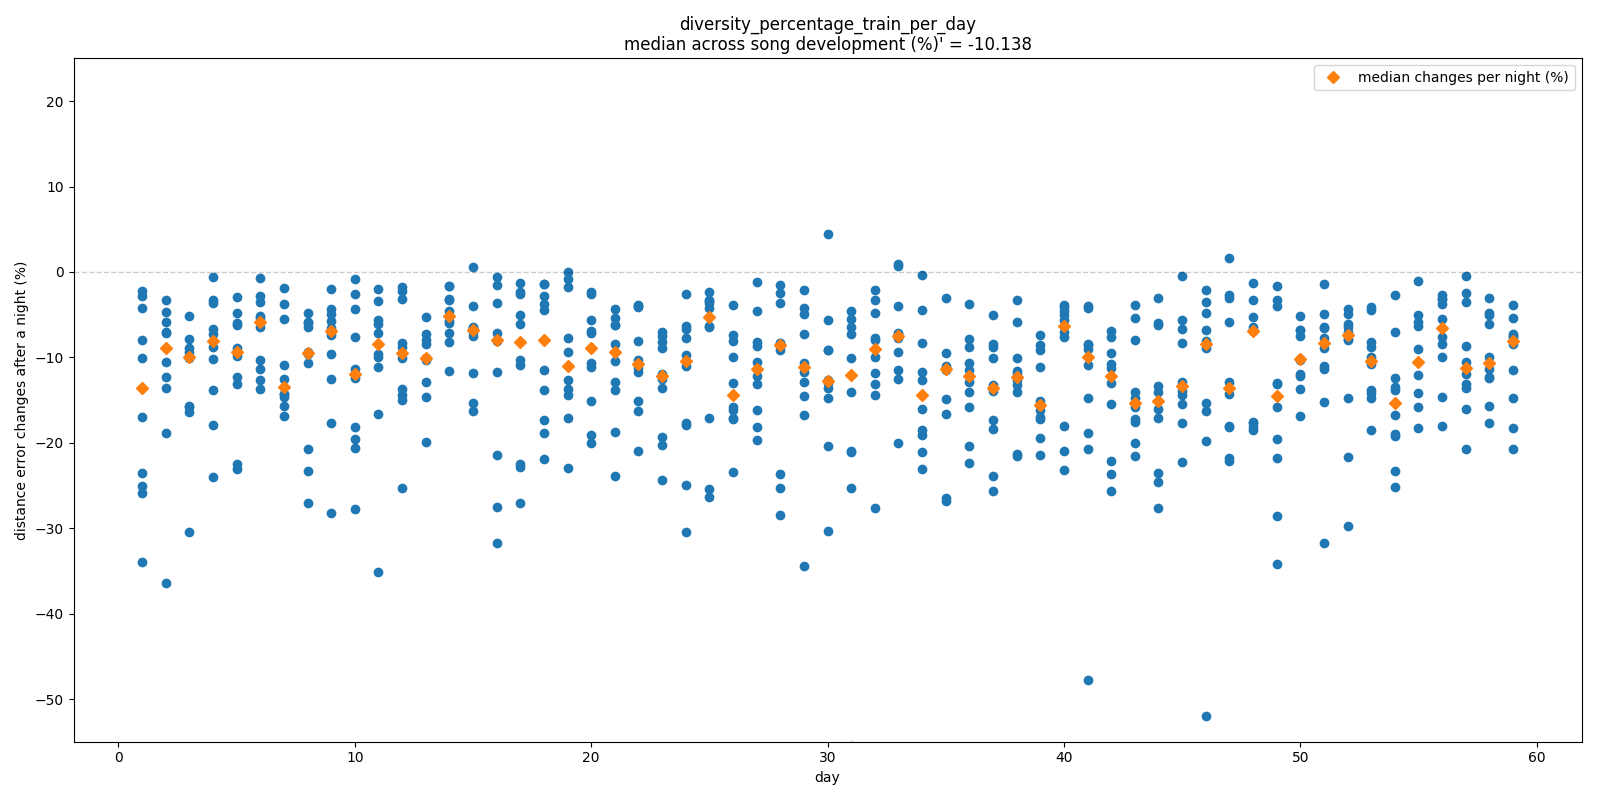

In [6]:
for i in range(len(night_p_ch)):  # for each div_th (parameters set)
    cluster_p_ch = deepcopy(night_p_ch[i])  #shape = (nb_seeds x nb_nights)
    cluster_p_ch *= 100  # Changing scale value: from 0.05 to 5%
    cluster_p_ch *= -1  # signed score percentage change (negative if against the overall developmental trend)
        
    fig = plt.figure(figsize=(fig_width,fig_height))
    # -- scatter plot --
    for i_bird in range(len(cluster_p_ch)):
        plt.plot(np.arange(1,len(cluster_p_ch[i_bird]) + 1), cluster_p_ch[i_bird],
                 'o', color='C0')
    median_p_ch_per_night = np.median(cluster_p_ch, axis=0)
    plt.plot(np.arange(1,cluster_p_ch.shape[1] + 1), median_p_ch_per_night,
             'D', color='C1', label="median changes per night (%)")
    plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
    plt.xlabel("day")
    plt.ylabel("distance error changes after a night (%)")
    plt.ylim(-55, 25)  # Same scale for all the figures
    plt.legend()
    str_title = "{}\n".format(plot_title)
    str_title += "median across song development (%)' = {}".format(round(np.median(cluster_p_ch), 3))
    plt.title(str_title)
    fig.tight_layout()
    plt.show()

# Closer to the Derégnaucourt et al. figure?

For each bird,  the median night percentage degradation during all the development and the mean value of its final songs' scores

In [7]:
# median percentage night deg for each bird
x_all_birds = 100 * np.median(np.concatenate(night_p_ch, axis=0), axis=1).flatten()
y_all_birds = -1 * np.concatenate(final_scores, axis=0).flatten()
# linear regression
z_all_birds = np.polyfit(x_all_birds, y_all_birds, 1)
print(z_all_birds)
p_all_birds = np.poly1d(z_all_birds)
# Spearman's rank correlation coefficient
r_x = rankdata(x_all_birds)
r_y = rankdata(y_all_birds)
spearman_corr_coef = np.corrcoef(r_x, r_y)[0, 1]
print("Spearman's rank correlation coefficient:", spearman_corr_coef)

[  0.20594813 -13.74555294]
Spearman's rank correlation coefficient: -0.05454545454545454


# Correlation plots

In [8]:
# give all the plots the same shape
# xmin, xmax, xstep = (8, 17, 0.5)
# ymin, ymax, ystep = (-14, -6.5, 0.25)

<IPython.core.display.Javascript object>


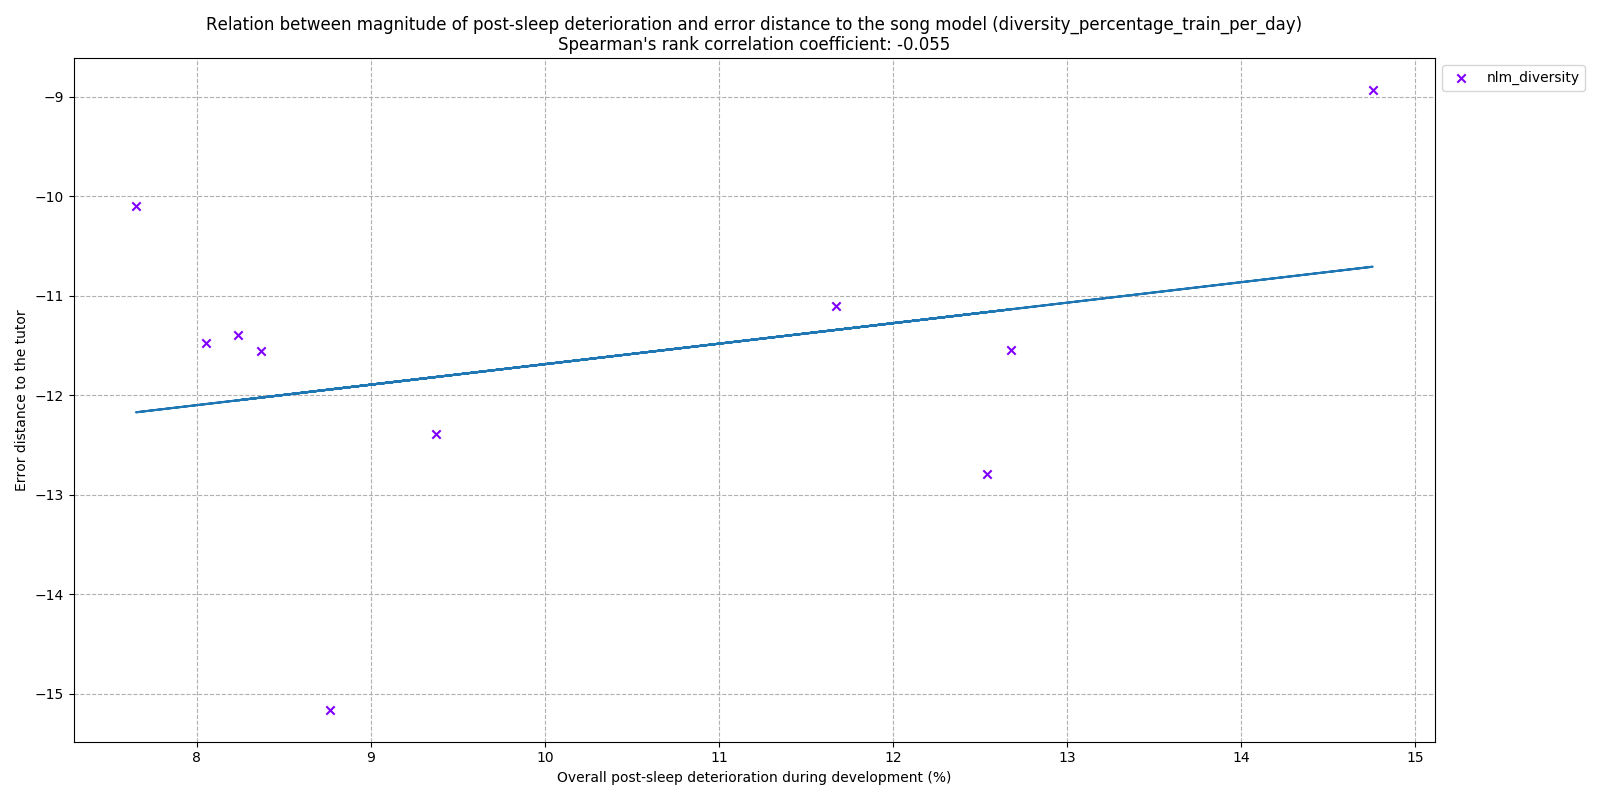

In [10]:
color_id = np.linspace(0, 1, len(night_data))
fig = plt.figure(figsize=(fig_width, fig_height))
for i in range(len(night_data)):
    # -- plot each bird --
    x_birds = 100 * np.median(night_p_ch[i], axis=1)
    plt.scatter(x=x_birds, y=-1 * final_scores[i],
                c=plt.cm.rainbow(color_id[i]),
                marker='x', label="nlm_diversity")
# -- Linear regressions --
plt.plot(x_all_birds, p_all_birds(x_all_birds))

# plt.xticks(np.arange(xmin, xmax + xstep))
# plt.xlim(xmin, xmax)
# plt.yticks(np.arange(ymin, ymax + ystep, ystep))
# plt.ylim(ymin, ymax)
plt.grid(ls='--')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Overall post-sleep deterioration during development (%)")
plt.ylabel("Error distance to the tutor")
str_title = "Relation between magnitude of post-sleep deterioration and error distance to the song model" 
str_title += " ({})".format(plot_title)
str_title += "\nSpearman's rank correlation coefficient: {}".format(round(spearman_corr_coef, 3))
plt.title(str_title)
fig.tight_layout()
plt.show()  